In [1]:
#For ku model
import numpy as np
import matplotlib.pyplot as plt
import os
from netCDF4 import Dataset
import environmental_file_gen as evgen #Generator functions by Kevin

#For landlab
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio
import xarray as xr
from scipy import ndimage
from netCDF4 import Dataset
from landlab import RasterModelGrid
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

In [2]:
# If running locally:
import sys
sys.path.append('permamodel/')

In [3]:
from permamodel.components import bmi_Ku_component

## Producing new files

First we need to run the code that creates new files for the parameter we will want to explore with the Ku model.

From Wang paper. Sag1 MNT -8.39degC average temp. Location: 69.433	-148.674

Wang, Kang, et al. "A synthesis dataset of permafrost-affected soil thermal conditions for Alaska, USA." Earth System Science Data (Online) 10.LA-UR-17-23049 (2018).

In [4]:
evgen.file_gen("./inputs/T_air.txt", 1000, -8.39, "slope", 1, 0.0486)

## Running Ku

In [5]:
# Tell Ku where to find the input file
cfg_file = os.path.join('./inputs/', 'canning_river.cfg')

# Set up a new instance of Ku
ku = bmi_Ku_component.BmiKuMethod()

# Initialize the model using the configuration file
ku.initialize(cfg_file)

 
Ku model component: Initializing...


In [6]:
# Decide on the number of time steps
# NOTE: If using time series inputs, nt / dt should equal the number of values in each time series
nt = ku.get_end_time() - ku.get_start_time()
dt = ku.get_time_step()

In [7]:
# Run the model! To interact with Ku between updates, modify this time loop
for i in range(int(nt)):
    ku.update()

# And then finalize the model run
ku.finalize()

***
Writing output finished!
Please look at./outputs/canning_river-ALT.nc and ./outputs/canning_river-TPS.nc


/opt/tljh/user/lib/python3.6/site-packages/permamodel/components/Ku_method.py:1266: UserWarning: WARNING: missing_value cannot be safely cast to variable dtype
  temp.missing_value = -999.99


A common error here looks like: 

`PermissionError: [Errno 13] Permission denied: b'./outputs/eightmile-ALT.nc'`

If you get this, delete the files in your outputs/ directory, then re-run the code cell above.

In [8]:
# Load the output files into arrays
alt_nc = Dataset('./outputs/canning_river-ALT.nc')
alt = alt_nc['data'][:,0,0]

tps_nc = Dataset('./outputs/canning_river-TPS.nc')
tps = tps_nc['data'][:,0,0]

# And, let's set non-physical values to NaN
alt[np.where(alt < 0)] = np.nan
tps[np.where(tps < -999)] = np.nan

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


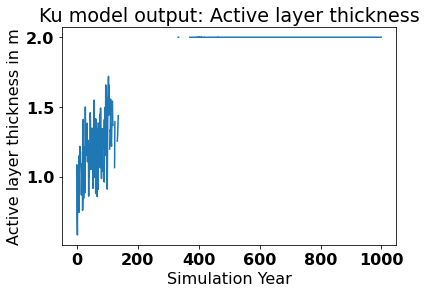

In [9]:
# Take a look at the outputs!
plt.plot(alt)
plt.xlabel('Simulation Year')
plt.ylabel('Active layer thickness in m')
plt.title('Ku model output: Active layer thickness')
plt.show()

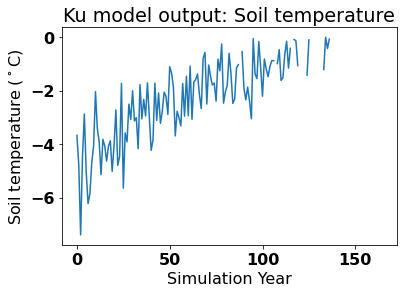

In [10]:
# Take a look at the outputs!
plt.plot(tps)
plt.xlabel('Simulation Year')
plt.ylabel('Soil temperature ($^\circ$C)')
plt.title('Ku model output: Soil temperature')
plt.show()

## Coupling with Landlab components

This notebook gives one *very simplistic* example for how Ku can be used alongside landscape geomorphology models. We will use the active layer depth results from Ku to drive a depth-dependent hillslope diffusion model over the Eight Mile Lake study site.

In [11]:
# Load a DEM
with rio.open('canning_river_dem.tif') as f:
    #data = f.read(1)
    fine_dem = f.read(1)

From this point onwards, the computational requirements of almost every step will scale with the size of this DEM. To save time, we can rescale it with typical image processing tools. I'll use xarray's coarsen() method here.

In [12]:
# SET TO ZERO FOR CANNING RIVER DUE TO DIMENSIONS WITH POOR LCD
# Coarsen the DEM 
xr_dem = xr.DataArray(fine_dem)
scale = 1
dem = xr_dem.coarsen(dim_0 = scale, dim_1 = scale).mean()

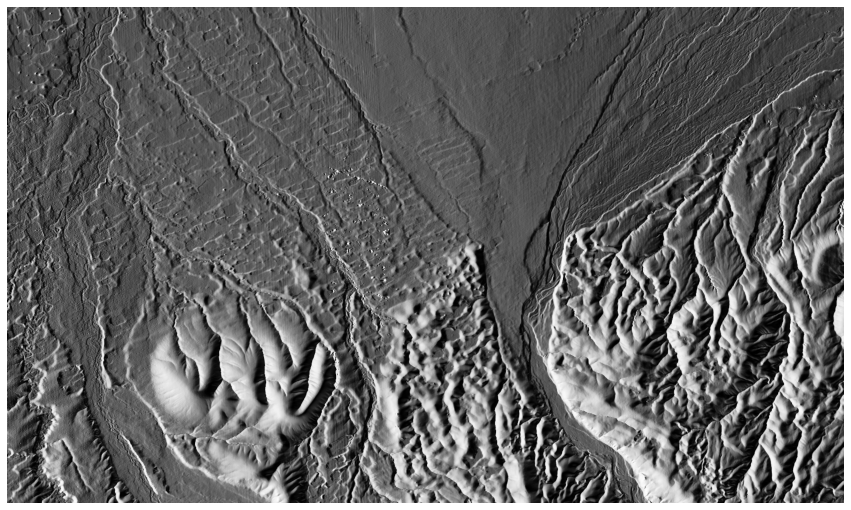

In [13]:
# Show the DEM
fig, ax = plt.subplots(figsize = (15, 15))

ls = LightSource(azdeg = 90, altdeg = 35)
shaded_dem = ls.hillshade(np.array(dem))

ax.imshow(shaded_dem, cmap = 'Greys')
plt.axis('off')
plt.show()

In [14]:
# First, load the netCDF4 file
alt_nc = Dataset('./outputs/canning_river-ALT.nc')

# Then, extract a time series of the active layer thickness data
alt = alt_nc.variables['data'][:,0,0]

# Set any negative values to NaN
alt[np.where(alt < 0)] = np.nan

# Interpolate through the NaN values 
mask = np.isnan(alt)
alt[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), alt[~mask])

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  """


Note that, you can ignore the warning that pops up here, code is still working properly below.

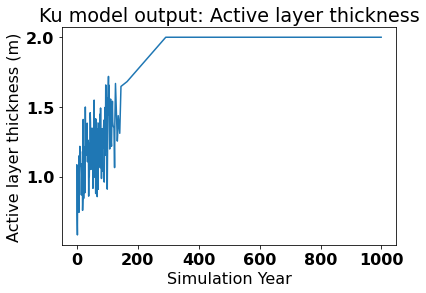

In [15]:
# Plot the active layer thickness dataset
plt.plot(alt)
plt.xlabel('Simulation Year')
plt.ylabel('Active layer thickness (m)')
plt.title('Ku model output: Active layer thickness')
plt.show()

### Landlab components

This is the simplest possible example, only using the Depth-Dependent Diffuser and no other inputs.

In [16]:
# First, make the model grid
grid = RasterModelGrid(dem.shape)

# Add fields for elevation and soil depth
z = grid.add_field('node', 'topographic__elevation', dem.astype(np.float64), units = 'm')
soilH = grid.add_field('node', 'soil__depth', np.full(grid.shape, alt[0], dtype = np.float64), units = 'm')
production = grid.add_zeros('soil_production__rate', at = 'node')

In [17]:
# Set parameter values
linear_diffusivity = 1e-2 # m^2 / yr
transport_decay_depth = 1 # m

In [18]:
# Initialize the Landlab component
ddiff = DepthDependentDiffuser(grid, linear_diffusivity, transport_decay_depth)

In [19]:
# Run the diffusion model

# Set the total runtime and time step size
nt = 300 # years
dt = 1 # years

# Prepare an array for outputs
out = np.ndarray([nt, grid.shape[0], grid.shape[1]])

# The main loop
for i in range(nt):
    
    # If array lengths match, index alt directly with the loop index
    if nt == len(alt):
        soilH[:] = alt[i]
        
    # Else, rescale the indices to match the length of the ALT array
    else:
        idx = int((i / nt) * (len(alt)))
        soilH[:] = alt[idx]
    
    # Step the diffusion component
    ddiff.run_one_step(dt)
    
    # Save out the elevation grid
    out[i] = grid.field_values('node', 'topographic__elevation').reshape(grid.shape)
    
    if i % 100 == 0:
        print('Completed year ' + str(i))

Completed year 0
Completed year 100
Completed year 200


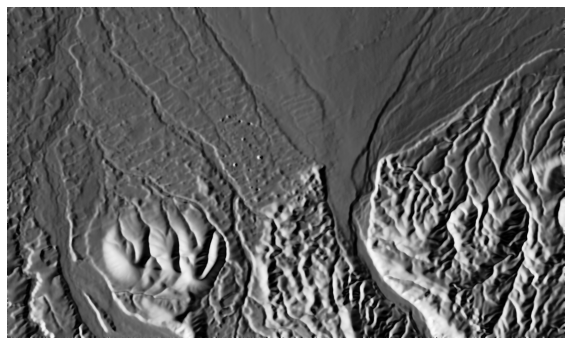

In [20]:
# Visualize the final landscape, after the model completed its run
# Note that there will be oddities around the edges, as we did not specify boundary conditions

fig, ax = plt.subplots(figsize = (10, 10))

ls = LightSource(azdeg = 90, altdeg = 35)
shaded_dem = ls.hillshade(out[-1])

ax.imshow(shaded_dem, cmap = 'Greys')
plt.axis('off')
plt.show()

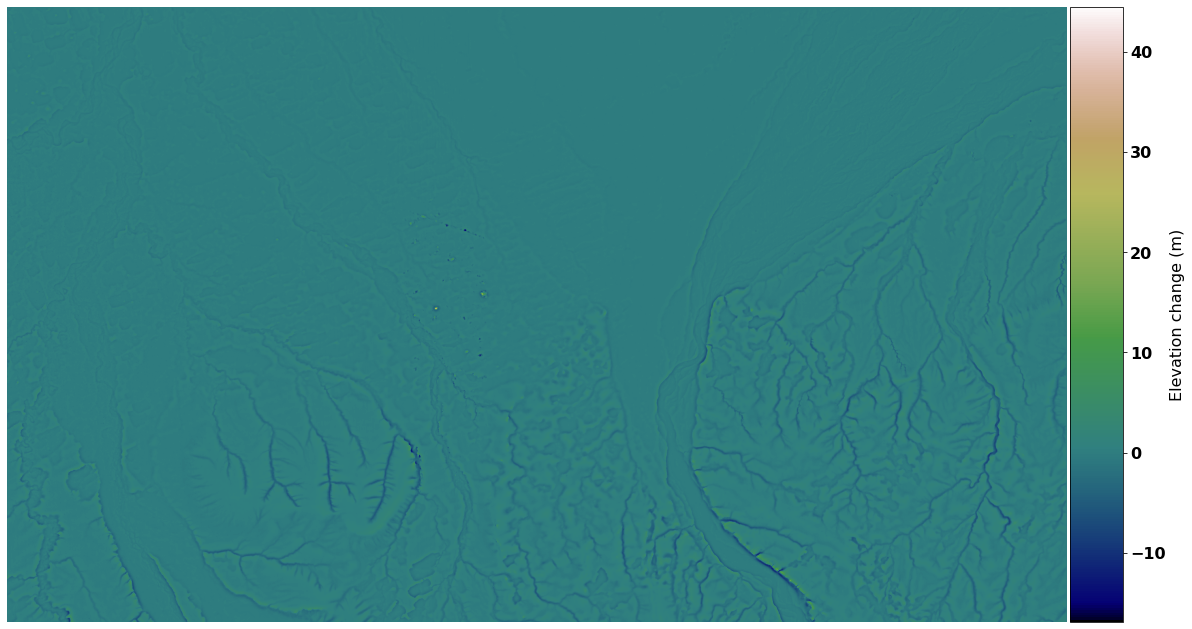

In [21]:
# Crop away the edges of the DEM
cropped = out[0,:-25,10:] - out[-1,:-25,10:]

# Then, visualize the difference from beginning to end at each grid cell
fig, ax = plt.subplots(figsize = (20, 20))
#im = ax.imshow(cropped, cmap = 'coolwarm')
im = ax.imshow(cropped, cmap = 'gist_earth')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, ax = ax, label = 'Elevation change (m)', cax=cax)

plt.show()